In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import shape
import matplotlib.ticker as ticker
%matplotlib inline

#### Load data into pandas 

In [2]:
df = pd.read_csv('WindPower2012.csv', error_bad_lines=False)
print("Length of original data : ", len(df))

# calculat the mean value for every hour and save as a new dataframe
data2 =[]   
for i in range (len(df)//12):
    data2.append(df[i * 12:(i + 1) * 12].mean())
data2 = pd.DataFrame(data2)
print("Length of hourly averaged data : ", len(data2))

# Get the values of the 6-11 columns
data= data2.iloc[:, 5:11].values

Length of original data :  105408
Length of hourly averaged data :  8784


#### Set Parameters:
Next we set the RNN model parameters. We will run the data through 100 epochs, in batch sizes of 14. The RNN will be of size 10 units.

In [3]:
rnn_unit = 10      #hidden layer units
input_size = 5
output_size=1
lr=0.0006         # learning rate

batch_size = 14   
time_step = 12    

train_begin=0 
train_end = 6000
test_begin = 6000
test_len = 180
iter_time = 100

# RNN output node weights and biases
weights = {
           'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
           'out':tf.Variable(tf.random_normal([rnn_unit,1]))
           }

biases = {
          'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
          'out':tf.Variable(tf.constant(0.1,shape=[1,]))
          }


#### Preparing the training data

In [4]:
# Get train data function: load training data for LSTM
# Input: batch_size, time_step, train_begin, train_end
# Output: batch_index, train_x, train_y

def get_train_data(batch_size, time_step, train_begin, train_end):
    batch_index = []
    
    # normalize the data
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))
    
    scaled_x_data = scaler_for_x.fit_transform(data)
    
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    
    # get train data
    normalized_train_data = scaled_x_data[train_begin:train_end]
    train_x, train_y = [], []
    for i in range(len(normalized_train_data) - time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x = normalized_train_data[i:i + time_step, 1:6]
        y = normalized_train_data[i:i + time_step, 0, np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data) - time_step))
    return batch_index, train_x, train_y 

####  Preparing the testing data

In [5]:
# Get test data function: load testing data for LSTM 
# Input: time_step, test_begin, test_len
# Output: test_x, test_y, scaler_for_x, scaler_for_y

def get_test_data(time_step, test_begin, test_len):
    
    # normalize the data
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    
    # get test data
    size = test_len// time_step 
    normalized_test_data = scaled_x_data[test_begin: (test_begin+test_len)]
    test_y = normalized_test_data[:,0]
    test_x = []
    for i in range(size):
        x = normalized_test_data[i * time_step:(i + 1) * time_step, 1:6]
        test_x.append(x.tolist())
    return test_x, test_y, scaler_for_x, scaler_for_y

#### Creating the LSTM network

In [6]:
# LSTM function: definition of recurrent neural network
# Input: X
# Output: pred, final_states

def lstm(X):
    batch_size = tf.shape(X)[0]
    time_step = tf.shape(X)[1]
    w_in = weights['in']
    b_in = biases['in']
    
    # reshape to (batch_size * time_step, input_size)
    input = tf.reshape(X, [-1, input_size])  #turn tensor to 3D-Array as the input of hidden layer
    input_rnn = tf.matmul(input, w_in) + b_in
    input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])
    
    # create an LSTM cell to be unrolled 
    cell = tf.contrib.rnn.BasicLSTMCell(rnn_unit)
    # cell=tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(rnn_unit)
    # cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    
    # At each time step, reinitialising the hidden state
    init_state = cell.zero_state(batch_size, dtype=tf.float32)
    
    # generate prediction
    # create a dynamic RNN object in TensorFlow. 
    # This object will dynamically perform the unrolling of the LSTM cell over each time step
    output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state,
                                                 dtype=tf.float32)
    
    output = tf.reshape(output_rnn, [-1, rnn_unit])
    w_out = weights['out']
    b_out = biases['out']
    ## Get the last output
    pred = tf.matmul(output, w_out) + b_out
    return pred, final_states

#### Training the LSTM Model and Making Predictions

In [7]:
# train_lstm function: train the LSTM model, make predictions, and calculate the error of predication 
# Input: batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len
# Output: test_y, test_predict, loss_list, rmse, mae

def train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len):
    # set up the state storage / extraction
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
    Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])    
    batch_index, train_x, train_y = get_train_data(batch_size, time_step, train_begin, train_end)
    
    print("Training parameters:***************************************************")
    print("batch size: ", batch_size)
    print("Number of batches: ", len(batch_index))
    print("Shape of training samples:", shape(train_x))
    print("Shape of training labels:", shape(train_y))

    pred, _ = lstm(X)
    
    ## Loss and optimizer
    loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    loss_list = []
    print("Training begins: *****************************************************")
    
    
    ## Training step optimization
    """
    The loss are accumulated to monitor the progress of the training. 
    20 iteration is generally enough to achieve an acceptable accuracy.
    """
    
    with tf.Session() as sess:
        # Initializing the variables
        sess.run(tf.global_variables_initializer())
        # repeat training 100 times
        for epoch in range(iter_time):
            for step in range(len(batch_index) - 2):
                ## Calculate batch loss
                _, loss_ = sess.run([train_op, loss], feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                                                 Y: np.array(train_y[batch_index[step]:batch_index[step + 1]], dtype=float).reshape(batch_size,time_step,1)})
                loss_list.append(loss_)
            
            # Show loss every 5 iterations   
            if epoch % 5 == 0:
                print("Epoch:", epoch, " loss:",loss_)
            
                #if step%100==0:
                    #print('Epoch:', epoch, 'steps: ', step,  'loss:', loss_)            
        print("Training Optimization Finished! ***************************************")
          
        """Testing the model"""
        print("Prediction Begins: ****************************************************")
        test_x, test_y, scaler_for_x, scaler_for_y = get_test_data(time_step, test_begin, test_len)
        print("Shape of testing samples:", shape(test_x))

                      
        test_predict = []
        for step in range(len(test_x)):
            prob = sess.run(pred, feed_dict={X: [test_x[step]]})
            predict = prob.reshape((-1))
            test_predict.extend(predict)
        #test_predict = scaler_for_y.inverse_transform(np.array(test_predict).reshape(-1,1))
        #test_y = scaler_for_y.inverse_transform(np.array(test_y).reshape(-1,1))
        
        test_y = np.array(test_y).reshape(-1,1)
        test_predict = np.array(test_predict).reshape(-1,1) 
        print("Shape of testing lables:", shape(test_predict))
        test_predict = scaler_for_y.inverse_transform(test_predict).reshape(-1,1)
        test_y= scaler_for_y.inverse_transform(test_y).reshape(-1,1)
       
        
        #calculate the error of predication 
        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        mae = mean_absolute_error(y_pred=test_predict, y_true=test_y)
        print ("Mean absolute error:", "{:.3f}".format(mae), 
               "Root mean squared error:", "{:.3f}".format(rmse))
        
        # visualization
        figure = plt.figure(figsize=(8,5))
        axes = figure.add_subplot(1, 1, 1, facecolor='ghostwhite')
        axes.plot(test_y, lw='2', c = 'red', label='Real Testing Data')     
        axes.plot(test_predict, lw='2', c = 'darkblue', label='LSTM Forecasted Data')
        axes.set_title('Real Testing vs. Forecasted Wind Power', fontsize = 12)
        axes.set_xlabel('Time Series', fontsize = 12)
        axes.set_ylabel('Wind Power(MWh)', fontsize = 12)
        axes.grid(ls = '--' , c = 'darkgrey', alpha=0.5)
        axes.legend(fontsize=12)
        
    return test_y, test_predict, loss_list, rmse, mae

Training parameters:***************************************************
batch size:  14
Number of batches:  429
Shape of training samples: (5988, 12, 5)
Shape of training labels: (5988, 12, 1)
Training begins: *****************************************************
Epoch: 0  loss: 0.02872518
Epoch: 5  loss: 0.009684304
Epoch: 10  loss: 0.005282224
Epoch: 15  loss: 0.0018140156
Epoch: 20  loss: 0.0005968761
Epoch: 25  loss: 0.00034159835
Epoch: 30  loss: 0.0002494173
Epoch: 35  loss: 0.00019426952
Epoch: 40  loss: 0.00014977869
Epoch: 45  loss: 0.00011207494
Epoch: 50  loss: 8.1880884e-05
Epoch: 55  loss: 6.0261606e-05
Epoch: 60  loss: 4.7140515e-05
Epoch: 65  loss: 4.0833762e-05
Epoch: 70  loss: 3.897193e-05
Epoch: 75  loss: 3.9042887e-05
Epoch: 80  loss: 3.8802773e-05
Epoch: 85  loss: 3.7443097e-05
Epoch: 90  loss: 3.5128716e-05
Epoch: 95  loss: 3.2350843e-05
Training Optimization Finished! ***************************************
Prediction Begins: **************************************

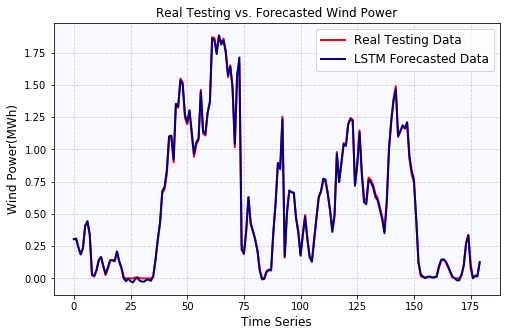

In [8]:
%%time
test_y, test_predict, loss_list, rmse, mae = train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len)

#### Plot loss change  during training procss

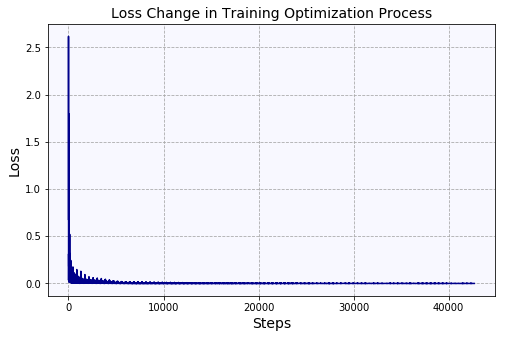

In [9]:
# Plot loss minimization during training procss
figure = plt.figure(figsize=(8,5))
axes = figure.add_subplot(1, 1, 1, facecolor='ghostwhite')
axes.plot(loss_list, c = 'darkblue')    
axes.set_title('Loss Change in Training Optimization Process', fontsize = 14)
axes.set_xlabel('Steps', fontsize = 14)
axes.set_ylabel('Loss', fontsize = 14)
axes.grid(ls = '--' , c = 'darkgrey')

#### Plot the LSTM predication results

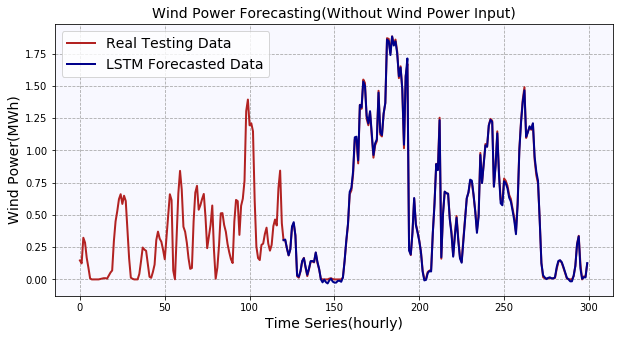

In [10]:
figure = plt.figure( figsize=(10,5))
axes = figure.add_subplot(1, 1, 1, facecolor='ghostwhite')
plot_data = data[:, 0]
axes.plot( plot_data[5880:6180], lw='2', c = 'firebrick', label='Real Testing Data')  
axes.plot([None for _ in range(120)] + [x for x in test_predict], lw='2', c = 'darkblue', label= 'LSTM Forecasted Data') 
axes.set_title('Wind Power Forecasting(Without Wind Power Input)', fontsize = 14)
axes.set_xlabel('Time Series(hourly)', fontsize = 14)
axes.set_ylabel('Wind Power(MWh)', fontsize = 14)
axes.grid(ls = '--' , c = 'darkgrey')
axes.legend(fontsize=14)
figure.savefig('Forecasted Wind Power.png') 

#### Plot the RMSE progression of LSTM with changing of  time steps

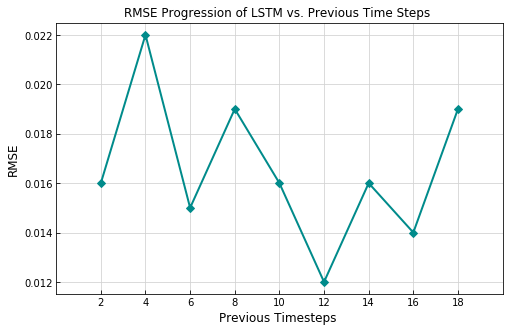

In [11]:
figure = plt.figure(figsize=(8,5))
axes = figure.add_subplot(1, 1, 1)

## Change time step to train LSTM, and record the RMSE and time to run to (with iter_time = 100, batch size = 14, rnn unit = 10)
Time_Steps = [2, 4, 6, 8, 10, 12, 14, 16, 18]
RMSE = [0.016, 0.022, 0.015,0.019,0.016, 0.012, 0.016, 0.014, 0.019]

axes.plot(Time_Steps, RMSE, '-gD', lw='2',  c = 'darkcyan') 
axes.set_title('RMSE Progression of LSTM vs. Previous Time Steps ', fontsize = 12)
axes.set_xlabel('Previous Timesteps ', fontsize = 12)
axes.set_ylabel('RMSE', fontsize = 12)
axes.grid(c = 'lightgrey') 
axes.set_xlim(0,20)

axes.tick_params(direction='in', length=4)
axes.xaxis.set_major_locator(ticker.FixedLocator((Time_Steps)))
figure.savefig('RMSE100.png') 